# Tuition Modeling
## Step 3: Finding Tuition vs Enrollment

The purpose of this script is to take data and models from Step 2 and run the genetic optimization algorithm for bucket values. First, bucket values will be created. Then the optimization will be run using DEAP.

### Goals

* Take gradient-boosting model for predictions and create buckets
* Run genetic algorithm for optimization
* Export optimized buckets for use later


### Process

* A. Load data and modules
* B. Define optimiziation constraints
* C. Set up for predictions
* D. Look at how predictions fared
* E. Create Curve


### Resources

* https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/pareto-optimized-road-trip/optimized-state-capitols-trip.ipynb

## Part A - Load data and modules

### Part A1 - Load modules

In [1]:
import sys
#sys.path.append("C:\\Python27\\Scripts")
print sys.path

['', 'C:\\Python27\\Scripts', 'C:\\Python27\\Lib\\site-packages', 'C:\\Program Files\\Python36\\Scripts', 'C:\\Users\\Lavi\\repos\\coursector\\pugo\\optimization', 'C:\\WINDOWS\\SYSTEM32\\python27.zip', 'c:\\python27\\DLLs', 'c:\\python27\\lib', 'c:\\python27\\lib\\plat-win', 'c:\\python27\\lib\\lib-tk', 'c:\\python27', 'C:\\Python27\\Lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Lavi\\.ipython']


In [2]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import random
import copy
from tqdm import tqdm
import scipy as sp
import scipy.optimize

# Get data-munging libraries
from sklearn import preprocessing
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

# Get Viz libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

# Genetic algorithm
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

C:\Python27\Lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


### Part A2 - Load  objects and data
These are objects that are created in Step 2: Enrollment Predictions

In [3]:
df = pd.read_csv('../predictions/forOpt/data_all.csv') #data used for the predictive model

In [4]:
model_location = '../predictions/forOpt/tuition/tuitionXgb_model.pkl' #the gradient boosting model
with open(model_location, 'rb') as model_input:
    predict_model_gb = pickle.load(model_input)
    
model_location = '../predictions/forOpt/tuition/tuitionRf_model.pkl' #the gradient boosting model
with open(model_location, 'rb') as model_input:
    predict_model_rf = pickle.load(model_input)
    
model_location = '../predictions/forOpt/tuition/tuitionNn_model.pkl' #the gradient boosting model
with open(model_location, 'rb') as model_input:
    predict_model_nn = pickle.load(model_input)

In [5]:
scaler_location = '../predictions/forOpt/tuition/scaler.pkl' #the scaler used. Will be scaling/re-scaling in this code

with open(scaler_location, 'rb') as scaler_input:
    scaler = pickle.load(scaler_input)

In [6]:
# features not used in predictions but are needed in this script
df[['PuGoOffer', 'GrantSchol', 'Tuition', 'ApplYr', 'IsAdmitted']] = pd.read_csv('../predictions/forOpt/pugoTuitionAndGrants.csv')

In [7]:
#names of columns for the predictive model
col_location = '../predictions/forOpt/tuition/columns.pkl'

with open(col_location, 'rb') as col_input:
    cols = pickle.load(col_input)

In [8]:
cutoff_threshold = 0.5 #default cutoff

useCutoff = True #use the one determined from model

use_only_admitted = True #should be kept true unless wanting to analyze students not given an offer

if useCutoff: #should be used, in most cases
    cutoff_location = '../predictions/forOpt/tuition/bestXgb_cutoff.pkl' #cutoff when setting thresholds for predictions
    with open(cutoff_location, 'rb') as cutoff_input:
        cutoff_threshold_gb = pickle.load(cutoff_input)
    cutoff_location = '../predictions/forOpt/tuition/bestRf_cutoff.pkl' #cutoff when setting thresholds for predictions
    with open(cutoff_location, 'rb') as cutoff_input:
        cutoff_threshold_rf = pickle.load(cutoff_input)
    cutoff_location = '../predictions/forOpt/tuition/bestNn_cutoff.pkl' #cutoff when setting thresholds for predictions
    with open(cutoff_location, 'rb') as cutoff_input:
        cutoff_threshold_nn = pickle.load(cutoff_input)

In [9]:
df.columns #some sanity checks below

Index([u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI',
       ...
       u'LowerHighSchoolGPA', u'UpperHighSchoolGPA', u'isAdmittedProbs',
       u'isAdmittedPredict', u'Enrolled', u'PuGoOffer', u'GrantSchol',
       u'Tuition', u'ApplYr', u'IsAdmitted'],
      dtype='object', length=113)

In [10]:
cols

Index([u'HolisticAcademicScore', u'HolisticPQAScore',
       u'HolisticAdmissionScore', u'parent1_ed_level', u'parent2_ed_level',
       u'HighestParentalEducation', u'TestScore', u'AcademicScore',
       u'AcademicRank', u'HS_AI',
       ...
       u'ed_3m', u'ed_4m', u'ed_5m', u'AcademicScore_imputed',
       u'tuition_after_grants', u'AcademicRankPctYr', u'LowerHighSchoolGPA',
       u'UpperHighSchoolGPA', u'isAdmittedProbs', u'isAdmittedPredict'],
      dtype='object', length=107)

## Part B - Define optimization constraints

In [11]:
years_to_use = [2017] #year(s) to include in optimization

## Part C - Set up for predictions

In [12]:
df = df[df.ApplYr.isin(years_to_use)] #use only years of interest

In [13]:
#optimize only on admitted students
if use_only_admitted:
    df = df[df.isAdmittedPredict == 1] 

In [14]:
#x and y variables in predictions
y = df.Enrolled
x = df.drop('Enrolled', axis = 1)

In [15]:
#some sanity checks follow
x.tuition_after_grants.describe()

count     9475.000000
mean     31583.763483
std       2553.404865
min       4912.000000
25%      31038.000000
50%      32288.000000
75%      32288.000000
max      35538.000000
Name: tuition_after_grants, dtype: float64

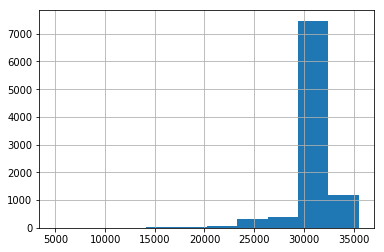

In [16]:
x.tuition_after_grants.hist()

In [17]:
x.PuGoOffer.value_counts()

3250    4745
4500    2854
0       1409
5500     467
Name: PuGoOffer, dtype: int64

In [18]:
scalerValues = pd.Series(scaler.scale_)
scalerValues.index = cols
centerValues = pd.Series(scaler.center_)
centerValues.index = cols

In [19]:
rescale = True #this is important - rescale the data to fit what is expected for the prediction models

if rescale:
    x_scaled = pd.DataFrame(scaler.transform(x[cols]), index = x.index, columns = cols)

## Part D - Look at how predictions fared

### See how predictions fared

In [20]:
enrollProb = predict_model_nn.predict_proba(x_scaled)[:,1] #probabilities for enrollment
enrollPrediction = enrollProb >= cutoff_threshold_nn #use cutoff threshold

In [21]:
#these values are actual amounts from the historical data
actual_pugo_offered = df.PuGoOffer.sum()
print 'PuGo Offered: ' + str(actual_pugo_offered)

actual_pugo_use = df[df.Enrolled == 1].PuGoOffer.sum()
print 'PuGo Use: ' + str(actual_pugo_use)

print 'PuGo use %: ' + str(float(actual_pugo_use) / actual_pugo_offered * 100)

PuGo Offered: 30832750
PuGo Use: 3221000
PuGo use %: 10.446684126456447


In [22]:
#these values are the predicted amounts for the given PuGo offers. Note how much there is an underestimation.
predicted_pugo_offered = df.PuGoOffer.sum()
print 'Predicted PuGo Offered: ' + str(predicted_pugo_offered)

predicted_pugo_use = df[enrollPrediction == 1].PuGoOffer.sum()
print 'Predicted PuGo Use: ' + str(predicted_pugo_use)

print 'Predicted PuGo use %: ' + str(float(predicted_pugo_use) / predicted_pugo_offered * 100)

Predicted PuGo Offered: 30832750
Predicted PuGo Use: 2480500
Predicted PuGo use %: 8.045017067890473


In [23]:
#actual student enrollment counts
actual_student_count = df.Enrolled.sum()
actual_total_student_count = len(df)

print 'Enrolled students: ' + str(actual_student_count)
print 'Admitted students: ' + str(actual_total_student_count)
print 'Actual yield: ' + str(actual_student_count * 100.0 / actual_total_student_count)

Enrolled students: 1140
Admitted students: 9475
Actual yield: 12.031662269129287


In [24]:
#predicted student enrollment counts
predicted_student_count = enrollPrediction.sum()
total_student_count = len(enrollPrediction)

print 'Predicted students: ' + str(predicted_student_count)
print 'Admitted students: ' + str(total_student_count)
print 'Predicted yield: ' + str(predicted_student_count * 100.0 / total_student_count)

Predicted students: 1083
Admitted students: 9475
Predicted yield: 11.430079155672823


In [25]:
predicted_net_revenue = (df.Tuition.mean() * enrollPrediction).sum()
print 'Predicted Net Revenue: ' + str(predicted_net_revenue) #predicted revenue, where revenue is just sum of tuition spent

Predicted Net Revenue: 38487654.0


In [26]:
predicted_avg_sat = df.TestScore[enrollPrediction == 1].mean()
print 'Predicted Average SAT: ' + str(predicted_avg_sat)

Predicted Average SAT: 1300.679593721145


In [27]:
use_scaler = predicted_pugo_use * 1.0 / actual_pugo_use #if there should be some scaling with respect to how much PuGo is used
use_scaler = 1.0

## Part E - Evaluation functions

### Part E1 - Make secondary functions

In [28]:
def reconstruct(valuesIn, tag):
    #get unscaled values from scaled values
    return (valuesIn * scalerValues[tag]) + centerValues[tag]

In [29]:
def deconstruct(valuesIn, tag):
    #get scaled values from unscaled values
    return (valuesIn - centerValues[tag]) / scalerValues[tag]

In [30]:
#this function will be used to evaluate scholarship amounts
def reCalculateTuition(dfIn):
    output = dfIn.copy() #copy input so as to not overwrite
    output['tuition_after_grants'] = output['Tuition'] - (output['PuGoOffer'] + output['GrantSchol']) #recalculate tuition
    output.loc[output.tuition_after_grants < 0, 'tuition_after_grants'] = 0
    output['tuition_after_grants'] = deconstruct(output['tuition_after_grants'], 'tuition_after_grants') #rescale!!
    return output 

In [31]:
opt_x = x_scaled.copy() #opt_x will be what we use in optimizations
opt_x[['PuGoOffer', 'GrantSchol', 'Tuition']] = df[['PuGoOffer', 'GrantSchol', 'Tuition']] #add these data variables

In [32]:
opt_x['PredictionScore'] = predict_model_gb.predict_proba(opt_x[cols])[:, 1] #generate initial prediction scores
opt_x['PredictionScoreTemp'] = opt_x['PredictionScore']
opt_x['EnrollPredictionTemp'] = predict_model_gb.predict(opt_x[cols])

In [33]:
opt_x.loc[opt_x.PredictionScoreTemp < cutoff_threshold_gb, 'EnrollPredictionTemp'] = 0 #look at initial predictions
opt_x.loc[opt_x.PredictionScoreTemp >= cutoff_threshold_gb, 'EnrollPredictionTemp'] = 1
len(opt_x[opt_x['EnrollPredictionTemp'] == 1])

1036

### Part E2 - Make evaluation function

In [34]:
def parse_scholarships_base(tuition, model, dfIn = opt_x, cutoff = cutoff_threshold):
    dfHold = dfIn.copy() #again, make a copy so original doesn't get altered
    
    dfHold['Tuition'] = tuition
    
    dfHold = reCalculateTuition(dfHold) #we then recalculate tuition (and rescale)
    
    dfHold['PredictionScoreTemp'] = model.predict_proba(dfHold[cols])[:, 1] #recalculate predictions
    dfHold.loc[dfHold.PredictionScoreTemp >= cutoff, 'EnrollPredictionTemp'] = 1
    dfHold.loc[dfHold.PredictionScoreTemp < cutoff, 'EnrollPredictionTemp'] = 0

    students = len(dfHold[dfHold['EnrollPredictionTemp'] == 1]) #students who we predict will enroll

    test_scores = reconstruct(dfHold.TestScore, 'TestScore') #this will make more sense if they are unscaled
    avg_test_score = test_scores[dfHold['EnrollPredictionTemp'] == 1].mean() #mean test score

    return students, avg_test_score

In [35]:
#skeleton function to call - essentially just has defaults to use built-in. Can be changed depending on style
def parse_scholarships(tuition, model, cutoff = cutoff_threshold, dfIn = opt_x):
    return parse_scholarships_base(tuition, model, dfIn, cutoff)

### Part E3 - Simulate tuition scenarios

In [36]:
print (cutoff_threshold_gb, cutoff_threshold_rf, cutoff_threshold_nn)

(0.226, 0.191, 0.199)


In [37]:
storeGb = []
storeRf = []
storeNn = []
tuition = np.arange(20000, 50000, 100)
for each in tqdm(tuition):
    storeGb.append(parse_scholarships(each, predict_model_gb, cutoff = cutoff_threshold_gb)[0])
    storeRf.append(parse_scholarships(each, predict_model_rf, cutoff = cutoff_threshold_rf)[0])
    storeNn.append(parse_scholarships(each, predict_model_nn, cutoff = cutoff_threshold_nn)[0])

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [08:18<00:00,  1.66s/it]


In [38]:
tuition = np.array(tuition)
storeGb = np.array(storeGb)
storeRf = np.array(storeRf)
storeNn = np.array(storeNn)
summed = (storeGb + storeRf + storeNn)/ 3
#summed = (storeRf + storeNn)/ 2

### Part E4 - Plot results

In [39]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

In [40]:
coefs = np.polyfit(tuition, np.log(summed), 1)

In [41]:
opt_params, parm_cov = sp.optimize.curve_fit(model_func, tuition,
                                             summed, p0 = (1000, coefs[0], coefs[1]), maxfev = 10000)
A, K, C = opt_params

In [42]:
opt_params

array([ 2.75452313e+04, -1.27488011e-04,  5.95213030e+02])

In [43]:
df.tuition_after_grants.mean()

31583.763482849605

In [44]:
predicted = A * np.exp(K * df.tuition_after_grants.mean()) + C
predicted

1086.5025123813987

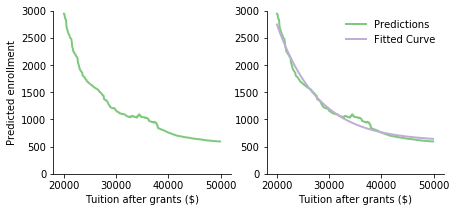

In [45]:
plt.figure(figsize = (7, 3))
ax = plt.subplot(121)

curve = A * np.exp(K * tuition) + C
#plt.plot(tuition, A * np.exp(K * tuition) + C )
plt.plot(tuition, summed, '#7fc97f', label = 'Predictions', linewidth = 2)
plt.xlabel('Tuition after grants ($)')
plt.ylabel('Predicted enrollment')
plt.ylim([0, 3000])
plt.xlim([18000, 52000])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


ax = plt.subplot(122)

curve = A * np.exp(K * tuition) + C
plt.plot(tuition, summed, '#7fc97f', label = 'Predictions', linewidth = 2)
plt.plot(tuition, A * np.exp(K * tuition) + C, '#beaed4', label = 'Fitted Curve', linewidth = 2)
plt.xlabel('Tuition after grants ($)')
#plt.ylabel('Predicted enrollment')
plt.ylim([0, 3000])
plt.xlim([18000, 52000])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon = False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('../optimization/forOpt/tuition/predictionCurveFitted.png', bbox_inches = 'tight')

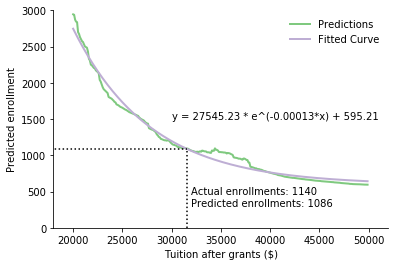

In [46]:
plt.figure(figsize = (6, 4))
ax = plt.subplot(111)

curve = A * np.exp(K * tuition) + C
plt.plot(tuition, summed, '#7fc97f', label = 'Predictions', linewidth = 2)
plt.plot(tuition, A * np.exp(K * tuition) + C, '#beaed4', label = 'Fitted Curve', linewidth = 2)
plt.plot([df.tuition_after_grants.mean(), df.tuition_after_grants.mean()], [0, predicted], 'k:')
plt.plot([0, df.tuition_after_grants.mean()], [predicted, predicted], 'k:')

equation = ['y = ', 
            str(np.round(opt_params[0], 2)),
            ' * e^(',
            str(np.round(opt_params[1], 5)),
            '*x) + ',
            str(np.round(opt_params[2], 2))]
plt.annotate(''.join(equation), xy = (30000, 1500))
plt.annotate('Actual enrollments: ' + str(actual_student_count) 
             + '\nPredicted enrollments: ' + str(int(predicted)), xy = (32000, 300))

plt.xlabel('Tuition after grants ($)')
plt.ylabel('Predicted enrollment')
plt.ylim([0, 3000])
plt.xlim([18000, 52000])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.legend(frameon = False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.savefig('../optimization/forOpt/tuition/predictionCurveAnnoted.png')

### TO DO: run monte carlos sims

In [104]:
plotX = np.linspace(-5, 0, 10000)

C:\Python27\Lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


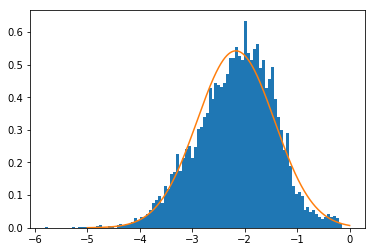

In [37]:
distGb = np.log(predict_model_gb.predict_proba(x_scaled[cols])[:, 1])
meanGb = np.mean(distGb)
stdGb = np.std(distGb)
plt.hist(np.log(predict_model_gb.predict_proba(x_scaled[cols])[:, 1]), bins = 100, density = True)
pdfGb = mlab.normpdf(plotX, meanGb, stdGb)
plt.plot(plotX, pdfGb)

C:\Python27\Lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


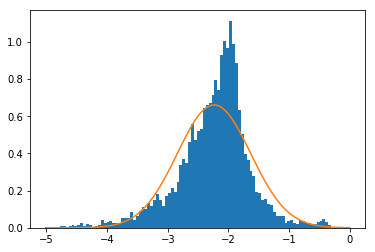

In [38]:
distRf = np.log(predict_model_rf.predict_proba(x_scaled[cols])[:, 1])
meanRf = np.mean(distRf)
stdRf = np.std(distRf)
plt.hist(np.log(predict_model_rf.predict_proba(x_scaled[cols])[:, 1]), bins = 100, density = True)
pdfRf = mlab.normpdf(plotX, meanRf, stdRf)
plt.plot(plotX, pdfRf)

C:\Python27\Lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


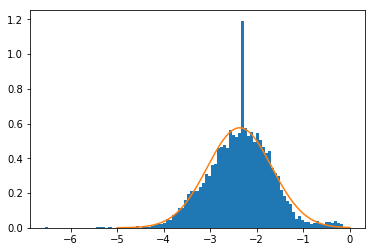

In [39]:
distNn = np.log(predict_model_nn.predict_proba(x_scaled[cols])[:, 1])
meanNn = np.mean(distNn)
stdNn = np.std(distNn)
plt.hist(np.log(predict_model_nn.predict_proba(x_scaled[cols])[:, 1]), bins = 100, density = True)
pdfNn = mlab.normpdf(plotX, meanNn, stdNn)
plt.plot(plotX, pdfNn)